MLB
LAST GAMES UPDATE: 2024-06-17 (9 GAMES)
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
Test Accuracy: 9.79131


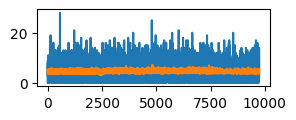

1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
   total_pred  spread_pred  total_score_pred               team_x
0    4.203107     -0.19115          8.725011    Baltimore Orioles
1    4.286759     -0.09211          8.813712  Cleveland Guardians


,total_pred,team_x
0,4.285320,Baltimore Orioles
1,4.390597,Cleveland Guardians


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step
   total_pred  spread_pred  total_score_pred                 team_x
0    4.086685    -0.328095          8.633841         Detroit Tigers
1    4.258934     0.122367          8.528160  Philadelphia Phillies


,total_pred,team_x
0,4.071783,Detroit Tigers
1,4.431051,Philadelphia Phillies


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step
   total_pred  spread_pred  total_score_pred            team_x
0    3.971582    -0.448041          8.542664    Tampa Bay Rays
1    4.149144     0.063337          8.361788  Seattle Mariners


,total_pred,team_x
0,3.972082,Tampa Bay Rays
1,4.369837,Seattle Mariners


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step
   total_pred  spread_pred  total_score_pred             team_x
0    4.530431     0.418585          8.777084     Boston Red Sox
1    4.305085    -0.091581          8.850165  Toronto Blue Jays


,total_pred,team_x
0,4.623077,Boston Red Sox
1,4.198526,Toronto Blue Jays


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step
   total_pred  spread_pred  total_score_pred              team_x
0    4.284787    -0.593722          9.322029  Pittsburgh Pirates
1    4.644567     0.400118          9.019429     Cincinnati Reds


,total_pred,team_x
0,4.154334,Pittsburgh Pirates
1,4.936019,Cincinnati Reds


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step
   total_pred  spread_pred  total_score_pred               team_x
0    4.407399     0.262636          8.681043       Atlanta Braves
1    4.245062    -0.093998          8.719543  St. Louis Cardinals


,total_pred,team_x
0,4.491904,Atlanta Braves
1,4.192326,St. Louis Cardinals


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step
   total_pred  spread_pred  total_score_pred               team_x
0    4.031158    -1.036149          9.252509    Chicago White Sox
1    4.922317     1.121691          8.858576  Los Angeles Dodgers


,total_pred,team_x
0,3.630470,Chicago White Sox
1,5.390891,Los Angeles Dodgers


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
   total_pred  spread_pred  total_score_pred              team_x
0    5.175151     1.416945          9.069831  Kansas City Royals
1    3.875895    -1.168559          9.084872       Miami Marlins


,total_pred,team_x
0,5.656128,Kansas City Royals
1,3.412894,Miami Marlins


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step
   total_pred  spread_pred  total_score_pred             team_x
0    4.236404    -0.412685          9.039800      Texas Rangers
1    5.201212     1.507953          9.038974  Milwaukee Brewers


,total_pred,team_x
0,3.753278,Texas Rangers
1,5.418767,Milwaukee Brewers


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step
   total_pred  spread_pred  total_score_pred              team_x
0    4.351273    -0.437184          9.288534   Oakland Athletics
1    4.638673     0.319097          9.111746  Los Angeles Angels


,total_pred,team_x
0,4.263844,Oakland Athletics
1,4.866117,Los Angeles Angels


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 327us/step
   total_pred  spread_pred  total_score_pred                team_x
0    3.894113    -0.495301          8.419404  Washington Nationals
1    4.600083     0.476425          8.857939      San Diego Padres


,total_pred,team_x
0,3.811017,Washington Nationals
1,4.779431,San Diego Padres


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step
   total_pred  spread_pred  total_score_pred                team_x
0    4.032176    -0.615695          8.824016          Chicago Cubs
1    4.663539     0.812551          8.660099  San Francisco Giants


,total_pred,team_x
0,3.768655,Chicago Cubs
1,4.957989,San Francisco Giants


,sport,home_team,away_team,h_score,a_score,time
0,MLB,Baltimore Orioles,Cleveland Guardians,4.285359,4.390836,06:35:00PM
1,MLB,Detroit Tigers,Philadelphia Phillies,4.071509,4.431031,06:40:00PM
2,MLB,Tampa Bay Rays,Seattle Mariners,3.971983,4.369743,06:50:00PM
3,MLB,Boston Red Sox,Toronto Blue Jays,4.622785,4.198137,07:10:00PM
4,MLB,Cincinnati Reds,Pittsburgh Pirates,4.935892,4.154379,07:10:00PM
5,MLB,St. Louis Cardinals,Atlanta Braves,4.192361,4.491988,07:45:00PM
6,MLB,Chicago White Sox,Los Angeles Dodgers,3.63059,5.39093,08:10:00PM
7,MLB,Kansas City Royals,Miami Marlins,5.655725,3.412858,08:10:00PM
8,MLB,Milwaukee Brewers,Texas Rangers,5.419021,3.753108,08:10:00PM
9,MLB,Los Angeles Angels,Oakland Athletics,4.866323,4.263753,09:38:00PM


NBA


,sport,home_team,away_team,h_score,a_score,time


NFL
LAST GAMES UPDATE: 2024-02-11 (1 GAMES)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 109.08374


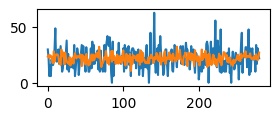

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
   total_pred  spread_pred  total_score_pred              team_x
0   23.099829     0.356675         45.827927    Baltimore Ravens
1   21.192902     0.254511         42.148521  Kansas City Chiefs


,total_pred,team_x
0,22.625129,Baltimore Ravens
1,21.465822,Kansas City Chiefs


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
   total_pred  spread_pred  total_score_pred               team_x
0   15.908081    -0.028623         31.951488  Philadelphia Eagles
1   18.518005     0.111204         36.987324    Green Bay Packers


,total_pred,team_x
0,16.432885,Philadelphia Eagles
1,18.020683,Green Bay Packers


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
   total_pred  spread_pred  total_score_pred             team_x
0   20.108011     0.196388         40.055229  Arizona Cardinals
1   26.224813     0.524095         51.857567      Buffalo Bills


,total_pred,team_x
0,21.180721,Arizona Cardinals
1,24.901074,Buffalo Bills


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
   total_pred  spread_pred  total_score_pred               team_x
0   19.054647     0.139954         38.022770      Atlanta Falcons
1   12.916368    -0.188903         26.178991  Pittsburgh Steelers


,total_pred,team_x
0,17.895826,Atlanta Falcons
1,14.161450,Pittsburgh Steelers


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
   total_pred  spread_pred  total_score_pred              team_x
0   14.954244    -0.079724         30.111063   Carolina Panthers
1   17.116457     0.036116         34.283043  New Orleans Saints


,total_pred,team_x
0,15.420188,Carolina Panthers
1,16.735267,New Orleans Saints


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
   total_pred  spread_pred  total_score_pred            team_x
0   22.200056     0.308469         44.091820  Tennessee Titans
1   27.177462     0.575133         53.695702     Chicago Bears


,total_pred,team_x
0,23.014293,Tennessee Titans
1,26.041469,Chicago Bears


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
   total_pred  spread_pred  total_score_pred                team_x
0   17.618847     0.063031         35.252399    Cincinnati Bengals
1   16.825802     0.020544         33.722225  New England Patriots


,total_pred,team_x
0,17.478149,Cincinnati Bengals
1,16.995595,New England Patriots


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
   total_pred  spread_pred  total_score_pred              team_x
0   21.669600     0.280050         43.068306  Indianapolis Colts
1   22.527889     0.326033         44.724373      Houston Texans


,total_pred,team_x
0,21.736871,Indianapolis Colts
1,22.259998,Houston Texans


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
   total_pred  spread_pred  total_score_pred                team_x
0   15.420006    -0.054771         31.009748  Jacksonville Jaguars
1   15.894110    -0.029371         31.924530        Miami Dolphins


,total_pred,team_x
0,15.563938,Jacksonville Jaguars
1,15.852110,Miami Dolphins


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
   total_pred  spread_pred  total_score_pred             team_x
0   26.610647     0.544766         52.602032    New York Giants
1   26.667336     0.547803         52.711414  Minnesota Vikings


,total_pred,team_x
0,26.414839,New York Giants
1,26.449421,Minnesota Vikings


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
   total_pred  spread_pred  total_score_pred            team_x
0   24.160341     0.413491         47.874180    Denver Broncos
1   23.653582     0.386342         46.896393  Seattle Seahawks


,total_pred,team_x
0,23.918781,Denver Broncos
1,23.610428,Seattle Seahawks


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
   total_pred  spread_pred  total_score_pred                team_x
0   17.191273     0.040124         34.427399     Las Vegas Raiders
1   17.116356     0.036111         34.282848  Los Angeles Chargers


,total_pred,team_x
0,17.192647,Las Vegas Raiders
1,17.146467,Los Angeles Chargers


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
   total_pred  spread_pred  total_score_pred            team_x
0   15.214687    -0.065771         30.613588  Cleveland Browns
1   19.687160     0.173841         39.243202    Dallas Cowboys


,total_pred,team_x
0,16.099460,Cleveland Browns
1,18.819882,Dallas Cowboys


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
Empty DataFrame
Columns: [total_pred, spread_pred, total_score_pred, team_x]
Index: []


IndexError: single positional indexer is out-of-bounds

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import date, datetime
from dotenv import load_dotenv
from IPython.display import display
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import random
import requests
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option('mode.use_inf_as_na', True)
load_dotenv()
API_KEY=os.getenv('ODDS_API_KEY')
DATE = date.today()
SIM = int(999e5)
SPORTS = ['baseball_mlb', 'basketball_nba', 'americanfootball_nfl', 'icehockey_nhl', 'basketball_ncaab', 'americanfootball_ncaaf']

try:
    os.remove('sims.csv')
except:
    pass

for SPORT in SPORTS:
    simulations = pd.DataFrame(columns=('sport','home_team','away_team','h_score','a_score','time'))

    sport = SPORT.split('_')[-1].upper()
    print(sport)

    response = requests.get(f'https://api.the-odds-api.com/v4/sports/{SPORT}/events?apiKey={API_KEY}')
    games = response.json()

    for i, game in enumerate(games):
        df = pd.read_csv(f"./data/{sport.lower()}_games.csv", index_col=0)
        df = df.sort_values('date').reset_index(drop=True)
        del df['index_opp']

        if i == 0:
            last_update = df["date"].iloc[-1]
            num_games = len(df[df["date"] == str(last_update)]) // 2
            print(f'LAST GAMES UPDATE: {last_update} ({num_games} GAMES)')
            
        nulls = pd.isnull(df).sum()
        nulls = nulls[nulls > 100]
        valid_columns = df.columns[~df.columns.isin(nulls.index)]
        df = df[valid_columns].copy()
        df.fillna(value=0, inplace=True)
            
        def add_targets(group):
            group['total_target'] = group['total'].shift(-1)
            group['spread_target'] = group['spread'].shift(-1)
            group['total_score_target'] = group['total_score'].shift(-1)
            return group
            
        df = df.groupby('team', group_keys=False).apply(add_targets)
        df['total_target'][pd.isnull(df['total_target'])] = -0.1
        df['spread_target'][pd.isnull(df['spread_target'])] = -0.1
        df['total_score_target'][pd.isnull(df['total_score_target'])] = -0.1
        df['total_target'] = df['total_target'].astype(float, errors='ignore')
        df['spread_target'] = df['spread_target'].astype(float, errors='ignore')
        df['total_score_target'] = df['total_score_target'].astype(float, errors='ignore')
            
        removed_columns = ['date','team','team_opp','total_target','spread_target','total_score_target']
        selected_columns = df.columns[~df.columns.isin(removed_columns)]

        scaler = MinMaxScaler()
        df[selected_columns] = scaler.fit_transform(df[selected_columns])
        
        def shift_col(team, col_name):
            next_col = team[col_name].shift(-1)
            return next_col
            
        def add_col(df, col_name):
            return df.groupby('team', group_keys=False).apply(lambda x: shift_col(x, col_name))
            
        df['home_next'] = add_col(df, 'home')
        df['team_opp_next'] = add_col(df, 'team_opp')
        df['date_next'] = add_col(df, 'date')
            
        home_team = game['home_team']
        away_team = game['away_team']
            
        null_indices = df[(df['team'] == home_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 1
            df.at[idx, 'team_opp_next'] = away_team
            df.at[idx, 'date_next'] = DATE
        null_indices = df[(df['team'] == away_team) & (df['home_next'].isnull())].index
        for idx in null_indices:
            df.at[idx, 'home_next'] = 0
            df.at[idx, 'team_opp_next'] = home_team
            df.at[idx, 'date_next'] = DATE

        df_rolling2 = df[list(selected_columns) + ['team']]
        df_rolling4 = df[list(selected_columns) + ['team']]
        df_rolling8 = df[list(selected_columns) + ['team']]

        def find_team_averages2(team):
            rolling = team.rolling(2).mean(numeric_only=True)
            return rolling
            
        df_rolling2 = df_rolling2.groupby(['team'], group_keys=False).apply(find_team_averages2)
        rolling_cols2 = [f'{col}_2' for col in df_rolling2.columns]
        df_rolling2.columns = rolling_cols2

        def find_team_averages4(team):
            rolling = team.rolling(4).mean(numeric_only=True)
            return rolling
                
        df_rolling4 = df_rolling4.groupby(['team'], group_keys=False).apply(find_team_averages4)
        rolling_cols4 = [f'{col}_4' for col in df_rolling4.columns]
        df_rolling4.columns = rolling_cols4

        def find_team_averages8(team):
            rolling = team.rolling(8).mean(numeric_only=True)
            return rolling
            
        df_rolling8 = df_rolling8.groupby(['team'], group_keys=False).apply(find_team_averages8)
        rolling_cols8 = [f'{col}_8' for col in df_rolling8.columns]
        df_rolling8.columns = rolling_cols8

        df = pd.concat([df, df_rolling2], axis=1)
        df = pd.concat([df, df_rolling4], axis=1)
        df = pd.concat([df, df_rolling8], axis=1)
        
        if SPORT != 'basketball_ncaab' and SPORT != 'americanfootball_ncaaf':
            df_rolling16 = df[list(selected_columns) + ['team']]
            df_rolling32 = df[list(selected_columns) + ['team']]
            df_matchup = df[list(selected_columns) + ['team','team_opp_next']]

            def find_team_averages16(team):
                rolling = team.rolling(16).mean(numeric_only=True)
                return rolling
                
            df_rolling16 = df_rolling16.groupby(['team'], group_keys=False).apply(find_team_averages16)
            rolling_cols16 = [f'{col}_16' for col in df_rolling16.columns]
            df_rolling16.columns = rolling_cols16
                
            def find_team_averages32(team):
                rolling = team.rolling(32).mean(numeric_only=True)
                return rolling
                
            df_rolling32 = df_rolling32.groupby(['team'], group_keys=False).apply(find_team_averages32)
            rolling_cols32 = [f'{col}_32' for col in df_rolling32.columns]
            df_rolling32.columns = rolling_cols32

            def find_team_matchup(team):
                rolling = team.rolling(2).mean(numeric_only=True)
                return rolling
                
            df_matchup = df_matchup.groupby(['team','team_opp_next'], group_keys=False).apply(find_team_matchup)
            matchup_cols = [f'{col}_matchup' for col in df_matchup.columns]
            df_matchup.columns = matchup_cols
            
            df = pd.concat([df, df_rolling16], axis=1)
            df = pd.concat([df, df_rolling32], axis=1)
            df = pd.concat([df, df_matchup], axis=1)
            
            df = df.dropna() 
                
            full = df.merge(df[rolling_cols2 + rolling_cols4 + rolling_cols8 + rolling_cols16 + rolling_cols32 + matchup_cols +
                            ['team_opp_next','date_next','team']], 
                            left_on=['team','date_next'], 
                            right_on=['team_opp_next','date_next'])
        else:
            df = df.dropna()

            full = df.merge(df[rolling_cols2 + rolling_cols4 + rolling_cols8 +
                            ['team_opp_next','date_next','team']], 
                            left_on=['team','date_next'], 
                            right_on=['team_opp_next','date_next'])
            
        removed_columns = list(full.columns[full.dtypes == 'object']) + removed_columns
        selected_columns = full.columns[~full.columns.isin(removed_columns)]

        if i == 0:
            train_df = full[full['total_target']!=-0.1]
            X = train_df[selected_columns].values
            y_total = train_df['total_target'].values
            y_spread = train_df['spread_target'].values
            y_total_score = train_df['total_score_target'].values

            input_layer = Input(shape=(len(selected_columns),))

            layer1 = Dense(125, activation='relu')(input_layer)
            layer2 = Dense(25, activation='relu')(layer1)
            layer3 = Dense(5, activation='relu')(layer2)

            output_total = Dense(1, name='total_output')(layer3)
            output_spread = Dense(1, name='spread_output')(layer3)
            output_total_score = Dense(1, name='total_score_output')(layer3)
            model = Model(inputs=input_layer, outputs=[output_total, output_spread, output_total_score])
            model.compile(optimizer='adam', loss='mse')

            split = TimeSeriesSplit(n_splits=5)
            early_stopping = EarlyStopping(patience=25)
            for train_index, test_index in split.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train_total, y_test_total = y_total[train_index], y_total[test_index]
                y_train_spread, y_test_spread = y_spread[train_index], y_spread[test_index]
                y_train_total_score, y_test_total_score = y_total_score[train_index], y_total_score[test_index]

                model.fit(X_train,
                        {'total_output': y_train_total, 'spread_output': y_train_spread, 'total_score_output': y_train_total_score},
                        epochs=125,
                        verbose=0,
                        callbacks=[early_stopping],
                        validation_data=(X_test, {'total_output': y_test_total, 'spread_output': y_test_spread, 'total_score_output': y_test_total_score}))
                
            test_df = train_df.iloc[test_index]
            test_predictions = model.predict(test_df[selected_columns])
            y_true = test_df['total_target'].values
            y_pred = test_predictions[0]
            mse = mean_squared_error(y_true, y_pred)
            print(f'Test Accuracy: {mse:.5f}')
            plt.figure(figsize=(3, 1))
            plt.plot(y_true)
            plt.plot(y_pred)
            plt.show()

            model.save('./model.keras')

        model = tf.keras.models.load_model('model.keras')
        predictions = model.predict(full[selected_columns])
        full['total_pred'] = predictions[0]
        full['spread_pred'] = predictions[1]
        full['total_score_pred'] = predictions[2]

        scores = full[full['total_target'] == -0.1].reset_index()
        print(scores[['total_pred','spread_pred','total_score_pred','team_x']])

        if scores['total_pred'].iloc[0] > scores['total_pred'].iloc[1]:
            win = 0
            lose = 1
        else:
            win = 1
            lose = 0
        spread = scores['total_pred'].iloc[win] - scores['total_pred'].iloc[lose]
        total_score = scores['total_pred'].iloc[win] + scores['total_pred'].iloc[lose]

        spread += scores['spread_pred'].iloc[win]
        spread -= scores['spread_pred'].iloc[lose]
        spread /= math.sqrt(3)
        
        total_score += scores['total_score_pred'].iloc[win]
        total_score += scores['total_score_pred'].iloc[lose]
        total_score /= 3
                
        win_mean = (total_score + spread) / 2
        lose_mean = (total_score - spread) / 2 
        if win_mean < 0:
            win_mean = 0
        if lose_mean < 0:
            lose_mean = 0
        win_team = scores['team_x'].iloc[win]
        lose_team = scores['team_x'].iloc[lose]

        win_score = np.mean(np.random.poisson(win_mean, SIM))
        lose_score = np.mean(np.random.poisson(lose_mean, SIM))

        scores['total_pred'].iloc[win] = win_score
        scores['total_pred'].iloc[lose] = lose_score
        display(scores[['total_pred', 'team_x']])

        time = datetime.strptime(game['commence_time'], '%Y-%m-%dT%H:%M:%S%z')
        eastern = pytz.timezone('US/Eastern')
        eastern_time = time.astimezone(eastern).strftime("%I:%M:%S%p")

        simulations.at[i, 'sport'] = sport

        simulations.at[i, 'home_team'] = home_team
        simulations.at[i, 'away_team'] = away_team
        simulations.at[i, 'time'] = eastern_time

        if win_team == home_team:
            simulations.at[i, 'h_score'] = win_mean
            simulations.at[i, 'a_score'] = lose_mean
        else:
            simulations.at[i, 'a_score'] = win_mean
            simulations.at[i, 'h_score'] = lose_mean

    simulations = simulations.sort_values(by=['time', 'home_team']).reset_index(drop=True)
    display(simulations)

    simulations = simulations.dropna()
    if not os.path.isfile('sims.csv'):
        simulations.to_csv('sims.csv', index=False)
    else:
        simulations.to_csv('sims.csv', mode='a', header=False, index=False)
    
os.remove('model.keras')